# Vivarium-Nucleus

Build-A-Cell #13 | MIT | 9/20/2024

## about
In this notebook we begin the schematization of Nucleus, to support the direct input of data into the Vivarium simulation framework.

## participants:
- Akshay Maheshwari
- Eran Agmon
- Natia Geliashvili

## some imports
here we import the process-bigraph library for simulations, and the bigraph-viz library for visualizing simulation schema

In [10]:
from bigraph_viz import plot_bigraph, generate_types, replace_regex_recursive
from process_bigraph import Process, Composite
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Detector cells

<!-- ![fig](DetectorCell/figs/detector_cell.png) -->
<img src="DetectorCell/figs/detector_cell.png" alt="detector cell fig" width="600"/>


In [7]:
cells = pd.read_csv("DetectorCell/data/20240806-detector-cells-data.csv")
cells.head()

,well,condition,timepoint,fluorescence [AU],tetR [nM],aTc [nM],DNA [nM],cell_ID_within_well,cell_area,cell_perimeter,cell_axis_major_length,cell_axis_minor_length
0,F11,positive,0,616.568480,0.0,0,0.5,4297,786,108.911688,40.282645,25.244045
1,F11,positive,0,527.468137,0.0,0,0.5,4422,575,92.083261,32.233444,23.224851
2,F11,positive,0,432.473580,0.0,0,0.5,1517,1936,196.066017,61.550863,46.755186
3,F11,positive,0,362.899801,0.0,0,0.5,223,1303,155.639610,61.455752,28.387717
4,F11,positive,0,559.009804,0.0,0,0.5,4518,937,113.154329,38.503535,31.352462


## Mean Intensity Traces

/var/folders/vy/vr0_ytms6m95qrnk7xnh0bth0000gq/T/ipykernel_47511/2862397345.py:1: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.lineplot(


<Axes: xlabel='timepoint', ylabel='fluorescence [AU]'>

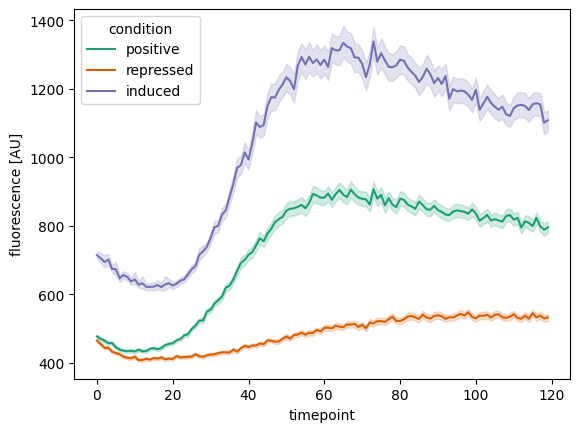

In [8]:
sns.lineplot(
    data=cells,
    x="timepoint",
    y="fluorescence [AU]",
    hue="condition",
    palette=sns.color_palette("Dark2"),
)

## Fog Plot

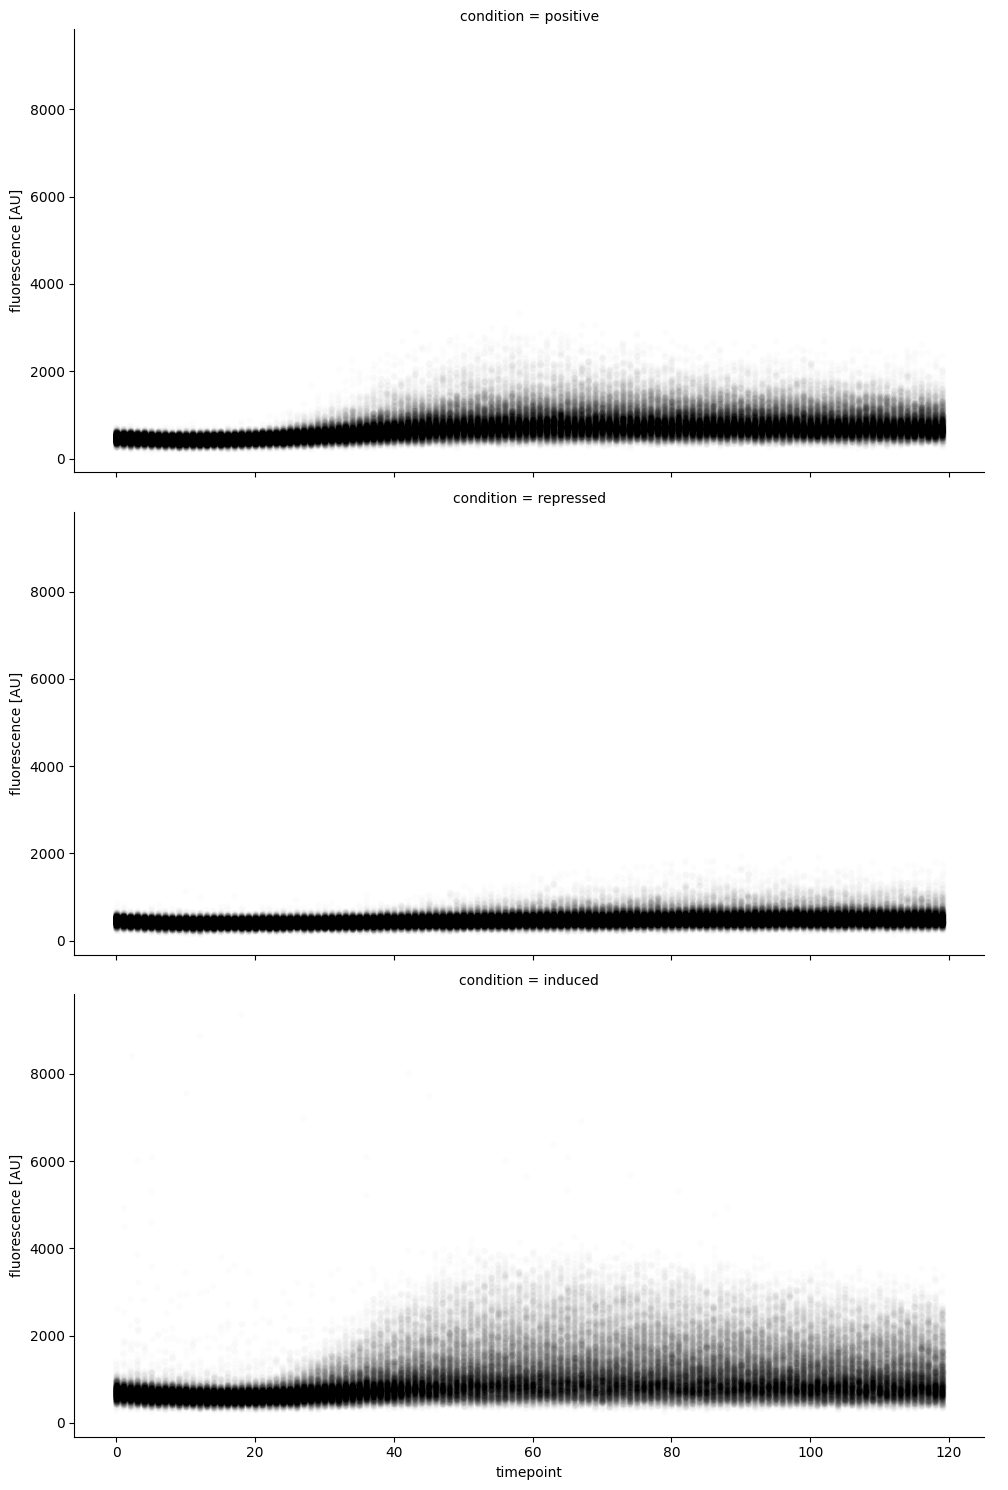

In [9]:
sns.catplot(
    data=cells,
    x="timepoint",
    y="fluorescence [AU]",
    color="black",
    row="condition",
    kind="strip",
    alpha=0.01,
    jitter=True,
    aspect=2,
    sharey=True,
    native_scale=True
)

## create the type system
Here we describe the data as it is available on Nucleus, so that we can check for consistency

In [2]:
core = generate_types()
core.register('pd.DataFrame', {'_inherit': 'any'})
core.register('cytosol', {'_inherit': 'pd.DataFrame'})
core.register('sequence', {'_inherit': 'string'})     # sequence is a string that uses only ATCG, promoters
core.register('concentration', {'_inherit': 'float'}) # positive float, units nM
core.register('DNA-module', {'sequence': 'sequence', 'concentration': 'concentration' }) 
core.register('membrane', {'_inherit': 'map'})        # {lipid name: concentration} also properties like volume, perimeter, rigidity
core.register('protein-module', {'_inherit': 'map'})  # {protein name: concentration}
core.register('reporter-protein', {'_inherit': 'concentration'})  # {protein name: concentration}
core.register('environment-module', {'_inherit': 'map'})  # {media component: concentration}
core.register('flourescence', {'_inherit': 'float'})  # amount of light detected

## Detector cell schema
This initial schema defines the detector cell in terms of the data types required, and the simulation processes that would predict GFP-fluorescence, and plots them.

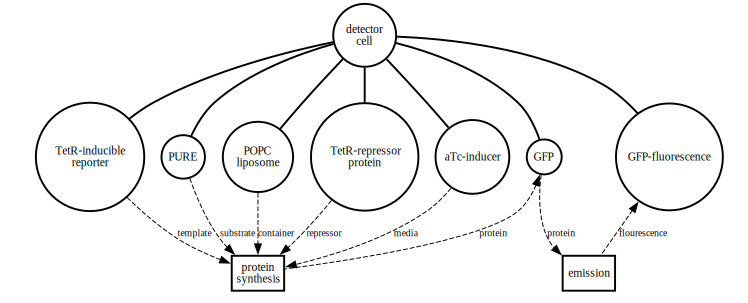

In [3]:
detector_cell = {
    'detector cell': {
        'TetR-inducible reporter': 'DNA-module',
        'PURE': 'cytosol',
        'POPC liposome': 'membrane',
        'TetR-repressor protein': 'protein-module',
        'aTc-inducer': 'environment-module',
        'GFP': 'reporter-protein',
        'GFP-fluorescence': 'flourescence',  # output
        'protein synthesis': {
            '_type': 'process',
            # 'address': 'local:bioscrape',  # This is how we would connect to a simulation module, by declaring where it is housed
            # 'config': {},                  # configure the process, using its specific terminology
            '_inputs': {
                'media': 'environment-module', 
                'repressor': 'protein-module',
                'container': 'membrane',
                'substrate': 'cytosol',
                'template': 'DNA-module',
            },
            '_outputs': {
                'protein': 'reporter-protein',
            },
            'inputs': {
                'media': ['aTc-inducer'],
                'repressor': ['TetR-repressor protein',],
                'container': ['POPC liposome',],
                'substrate': ['PURE',],
                'template': ['TetR-inducible reporter',],
            },
            'outputs': {
                'protein': ['GFP']
            }
        },
        'emission': {
            '_type': 'process',
            '_inputs': {'protein': 'reporter-protein'},
            '_outputs': {'flourescence': 'flourescence'},
            'inputs': {'protein': ['GFP']},
            'outputs': {'flourescence': ['GFP-fluorescence']}
        }
    }
}

detector_cell = replace_regex_recursive(detector_cell)
plot_bigraph(detector_cell, core=core, remove_process_place_edges=True,
             # show_types=True
            )

## begin sketching out the broader Nucleus schema

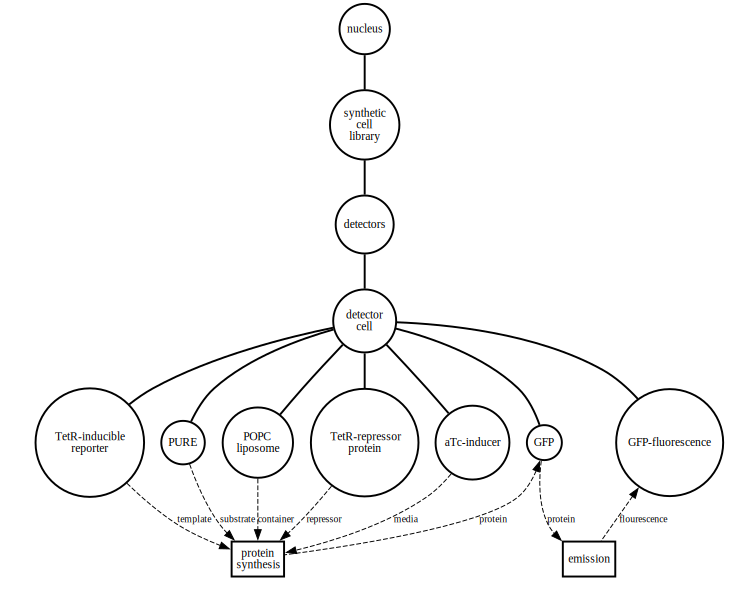

In [4]:
nucleus = {
    'nucleus': {
        'synthetic cell library': {
            'detectors': detector_cell
        },
    },
}

nucleus = replace_regex_recursive(nucleus)
plot_bigraph(nucleus, core=core, remove_process_place_edges=True)

## in progress code below (view at your own discretion)

In [11]:
detector_cell_sim = Composite()

In [ ]:
detector_cell_sim['PURE'] = {}

In [ ]:
detector_cell_sim.run(time=10)

In [ ]:
class ProteinSynthesis(Process):
    default_config = {}
    def __init__(self, config, core):
        pass
    def inputs(self):
        return {
                'media': 'environment-module', 
                'repressor': 'protein-module',
                'container': 'membrane',
                'substrate': 'cytosol',
                'template': 'DNA-module',
            }
    def outputs(self):
        return {}
    def update(self, states, interval):
        # do some math here
        return {}

# core.register('protein_synthesis', ProteinSynthesis)